# Prepare

In [1]:
import warnings
warnings.filterwarnings('ignore')
import cv2
import sys
import os
sys.path.append(os.path.abspath('..'))
from typing import Union, List
from enum import Enum
import json

from PIL import Image
import numpy as np

import torch
import torchvision.models as models

import matplotlib.pyplot as plt

import pytorch_grad_cam as cam
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
class CAMType(Enum):
    GRAD_CAM = cam.GradCAM
    HI_RES_CAM = cam.HiResCAM
    GRAD_CAM_ELEMENT_WISE = cam.GradCAMElementWise
    ABLATION_CAM = cam.AblationCAM
    X_GRAD_CAM = cam.XGradCAM
    GRAD_CAM_PLUS_PLUS = cam.GradCAMPlusPlus
    SCORE_CAM = cam.ScoreCAM
    LAYER_CAM = cam.LayerCAM
    EIGEN_CAM = cam.EigenCAM
    EIGEN_GRAD_CAM = cam.EigenGradCAM
    KPCA_CAM = cam.KPCA_CAM
    RANDOM_CAM = cam.RandomCAM
    FULL_GRAD = cam.FullGrad

from typing import List, Callable

def get_cam(cam_type: CAMType, model: torch.nn.Module, target_layers: torch.nn.Module):
    cam_class = cam_type.value
    return cam_class(model=model, target_layers=target_layers)

def visualize(grayscale: torch.Tensor, rgb_img: np.ndarray):
    visualization = show_cam_on_image(rgb_img, grayscale, use_rgb=True)
    plt.imshow(visualization)
    plt.axis('off')
    plt.show()

def display_images_in_rows(rgb_img: np.ndarray, grayscale_list: List[torch.Tensor], labels: List[str]):
    """
    Displays a list of images in rows, with each row containing up to max_images_per_row images.
    
    Args:
        images (list of np.ndarray): List of images to display.
        labels (list of str): List of labels for each image.
        max_images_per_row (int): Maximum number of images per row (default is 4).
    """

    images = [rgb_img]

    for grayscale in grayscale_list:
        images.append(show_cam_on_image(rgb_img, grayscale, use_rgb=True))

    labels.insert(0, "Image")

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    # Loop through the images and labels to display them
    for ax, img, label in zip(axes, images, labels):
        ax.imshow(img)  # Show the image
        ax.set_title(label)  # Set the title
        ax.axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

def execute_cam(
        img_path: str,
        model: torch.nn.Module,
        target_layers: List[torch.nn.Module],
        cam_type: CAMType,
        targets: Union[List[ClassifierOutputTarget], None] = None,
        visualization: bool = False,
        output_path: Union[str, None] = None
    ):
        model_name = "unknown"
        target_layer_name = "unknown"
        try:
            model_name = model._get_name()
            target_layer_name = target_layers[0]._get_name()
        except:
            pass

        print(f"Executing CAM on {model_name} with target layer {target_layer_name}:")

        img = np.array(Image.open(img_path).convert("RGB"))
        img = cv2.resize(img, (224, 224))
        img = np.float32(img) / 255
        input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        # Forward to get target class if not specified
        if not targets:
            with torch.no_grad():
                predicted_class = model(input_tensor).max(1)[-1]
                targets = [ClassifierOutputTarget(predicted_class)]
                print(predicted_class)
                print(f"Target class: {labels[str(predicted_class.item())][1]}")

        cam = get_cam(cam_type=cam_type, model=model, target_layers=target_layers)

        # Generate the CAM
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

        # Overlay the CAM on the image
        if visualization:
            # Convert the PIL image to a NumPy array for visualization
            rgb_img = np.array(rgb_img.resize((224, 224))) / 255.0  # Normalize the pixel values
            
            visualize(grayscale=grayscale_cam[0, :], rgb_img=rgb_img)

            # Optionally, you can save the resulting CAM visualization
            if output_path:
                Image.fromarray((visualization * 255).astype(np.uint8)).save(output_path)
                print(f"Saved output image to {output_path}")

        return grayscale_cam, input_tensor

labels = json.load(open("../pytorch_grad_cam/utils/imagenet_class_index.json"))

In [2]:
class PerturbationConfidenceMetric:
    def __init__(self, perturbation):
        self.perturbation = perturbation

    def __call__(self, input_tensor: torch.Tensor,
                 cams: np.ndarray,
                 targets: List[Callable],
                 model: torch.nn.Module,
                 return_visualization=False,
                 return_diff=True):

        if return_diff:
            with torch.no_grad():
                outputs = model(input_tensor)
                scores = [target(output).cpu().numpy()
                          for target, output in zip(targets, outputs)]
                scores = np.float32(scores)

        batch_size = input_tensor.size(0)
        perturbated_tensors = []
        for i in range(batch_size):
            cam = cams[i]
            tensor = self.perturbation(input_tensor[i, ...].cpu(),
                                       torch.from_numpy(cam))
            tensor = tensor.to(input_tensor.device)
            perturbated_tensors.append(tensor.unsqueeze(0))
        perturbated_tensors = torch.cat(perturbated_tensors)

        with torch.no_grad():
            outputs_after_imputation = model(perturbated_tensors)
        scores_after_imputation = [
            target(output).cpu().numpy() for target, output in zip(
                targets, outputs_after_imputation)]
        scores_after_imputation = np.float32(scores_after_imputation)

        if return_diff:
            result = scores_after_imputation - scores
        else:
            result = scores_after_imputation

        if return_visualization:
            return result, scores, scores_after_imputation, perturbated_tensors
        else:
            return result, scores, scores_after_imputation

def multiply_tensor_with_cam(input_tensor: torch.Tensor,
                             cam: torch.Tensor):
    """ Multiply an input tensor (after normalization)
        with a pixel attribution map
    """
    return input_tensor * cam
        
class CamMultImageConfidenceChange(PerturbationConfidenceMetric):
    def __init__(self):
        super(CamMultImageConfidenceChange,
              self).__init__(multiply_tensor_with_cam)
        
class DropInConfidence(CamMultImageConfidenceChange):
    def __init__(self):
        super(DropInConfidence, self).__init__()

    def __call__(self, *args, **kwargs):
        scores, scores_before, scores_after = super(DropInConfidence, self).__call__(*args, **kwargs)
        scores = -scores
        return np.maximum(scores, 0) / scores_before * 100


class IncreaseInConfidence(CamMultImageConfidenceChange):
    def __init__(self):
        super(IncreaseInConfidence, self).__init__()

    def __call__(self, *args, **kwargs):
        scores, bef_score, scores_after = super(IncreaseInConfidence, self).__call__(*args, **kwargs)
        return np.float32(scores > 0)

# Body

## Choose model & method

In [3]:
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT).eval()
target_layers = [model.features[28]]

cam_type = CAMType.GRAD_CAM_PLUS_PLUS

## Calculate increase in confidence

Executing CAM on VGG with target layer Conv2d:
tensor([270])
Target class: white_wolf


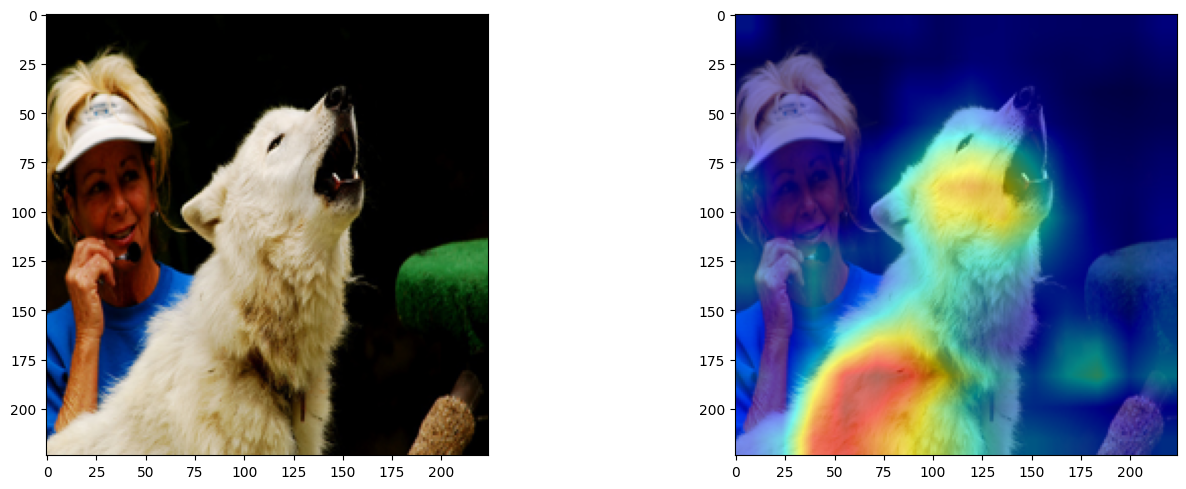

In [4]:
img_path = "../images/ILSVRC2012_val_00000091.JPEG"
gray_scale, input_tensor = execute_cam(img_path=img_path, model=model, target_layers=target_layers, cam_type=cam_type)
rgb_img = Image.open(img_path).convert('RGB')
rgb_img = np.array(rgb_img.resize((224, 224))) / 255.0
img_saliency = show_cam_on_image(rgb_img, gray_scale[0, :], use_rgb=True)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(rgb_img)
axes[1].imshow(img_saliency)

plt.tight_layout()
plt.show()

Confidence before imputation: [[0.6517022]]
Confidence after imputation: [[0.01919184]]
The confidence increase raw: [-0.63251036]
The drop in confidence percentage: [[97.05512]]%
The increase in confidence: [[0.]]
The visualization of the pertubated image for the metric:


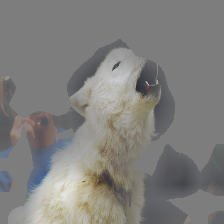

In [5]:
# Add threshold
threshold = np.percentile(gray_scale, 50)

gray_scale[gray_scale < threshold] = 0
# gray_scale = gray_scale > threshold

predicted_class = model(input_tensor).max(1)[-1]
# targets = [ClassifierOutputTarget(predicted_class)]
targets = [ClassifierOutputSoftmaxTarget(predicted_class)]
cam_metric = CamMultImageConfidenceChange()
scores, scores_before, scores_after, visualizations = cam_metric(input_tensor, gray_scale, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
drop_in_conf_metric = DropInConfidence()
increase_in_conf_metric = IncreaseInConfidence()
drop_in_conf = drop_in_conf_metric(input_tensor, gray_scale, targets, model)
increase_in_conf = increase_in_conf_metric(input_tensor, gray_scale, targets, model)

print(f"Confidence before imputation: {scores_before}")
print(f"Confidence after imputation: {scores_after}")
print(f"The confidence increase raw: {score}")
print(f"The drop in confidence percentage: {drop_in_conf}%")
print(f"The increase in confidence: {increase_in_conf}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

## Average drop & Average increase

In [6]:
# cam_metric = CamMultImageConfidenceChange()

# # Initialize metrics to calculate averages
# drop_in_conf_metric = DropInConfidence()
# increase_in_conf_metric = IncreaseInConfidence()

# total_drop_in_conf = 0
# total_increase_in_conf = 0
# num_images = 0  # to keep track of number of processed images

# input_folder = "C:\Users\HaPham\Documents\ThesisXAI\Code\CAM-combination\ILSVRC2012\ILSVRC2012_img_val"
# imputated_folder = "../imputated_images"  # Specify your desired folder path
# for filename in os.listdir(input_folder):
#     if filename.endswith(('.jpg', '.JPEG', '.png')):
#         img_path = os.path.join(input_folder, filename)

#         # Execute CAM for the current image
#         gray_scale, input_tensor = execute_cam(img_path=img_path, model=model, target_layers=target_layers, cam_type=cam_type)
#         # threshold = np.percentile(gray_scale, 50)
#         # gray_scale[gray_scale < threshold] = 0

#         # Load and preprocess the image for CAM overlay
#         rgb_img = Image.open(img_path).convert('RGB')
#         rgb_img = np.array(rgb_img.resize((224, 224))) / 255.0
#         img_saliency = show_cam_on_image(rgb_img, gray_scale[0, :], use_rgb=True)

#         # Calculate predicted class and confidence score change
#         predicted_class = model(input_tensor).max(1)[-1]
#         targets = [ClassifierOutputTarget(predicted_class)]
#         scores, scores_before, scores_after, visualizations = cam_metric(input_tensor, gray_scale, targets, model, return_visualization=True)
        
#         # Calculate Drop in Confidence and Increase in Confidence
#         drop_in_conf = drop_in_conf_metric(input_tensor, gray_scale, targets, model)
#         increase_in_conf = increase_in_conf_metric(input_tensor, gray_scale, targets, model)
        
#         # Accumulate the scores for averaging
#         total_drop_in_conf += drop_in_conf
#         total_increase_in_conf += increase_in_conf
#         num_images += 1  # Increment image count

#         # Process the visualization for display and scoring
#         score = scores[0]
#         visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
#         visualization = deprocess_image(visualization)
        
#         # Print individual results
#         print(f"Image: {filename}")
#         print(f"Confidence before imputation: {scores_before}")
#         print(f"Confidence after imputation: {scores_after}")
#         print(f"The confidence increase raw: {score}")
#         print(f"The drop in confidence percentage: {drop_in_conf}%")
#         print(f"The increase in confidence: {increase_in_conf}")
#         Image.fromarray(visualization).save(os.path.join(imputated_folder, f"{filename}"))
#         print("----------------------------------------")

# # Calculate and print averages after processing all images
# if num_images > 0:
#     avg_drop_in_conf = total_drop_in_conf / num_images
#     avg_increase_in_conf = total_increase_in_conf / num_images
#     print(f"\nNumber of images: {num_images}")
#     print(f"Average Drop in Confidence: {avg_drop_in_conf}%")
#     print(f"Average Increase in Confidence: {avg_increase_in_conf}%")
# else:
#     print("No images found in the specified folder.")

In [7]:
import os
import random
from PIL import Image
import numpy as np
import torch
import shutil

# Paths
input_folder = r"C:\Users\HaPham\Documents\ThesisXAI\Code\CAM-combination\ILSVRC2012\ILSVRC2012_img_val"
imputated_folder = "../imputated_images"

if os.path.exists(imputated_folder):
    shutil.rmtree(imputated_folder)
os.makedirs(imputated_folder)

# Generate a list of image names within the specified range
start_idx = 1
end_idx = 50000
num_images_to_sample = 100  # Adjust this to how many random images you want

all_image_names = [
    f"ILSVRC2012_val_{i:08d}.JPEG" for i in range(start_idx, end_idx + 1)
]
random_image_names = random.sample(all_image_names, num_images_to_sample)

# # Initialize metrics
# total_drop_in_conf = 0
# total_increase_in_conf = 0
# num_images = 0  # Track number of processed images

# # Process the randomly selected images
# for filename in random_image_names:
#     img_path = os.path.join(input_folder, filename)

#     if os.path.exists(img_path):  # Ensure the file exists
#         # Execute CAM for the current image
#         gray_scale, input_tensor = execute_cam(img_path=img_path, model=model, target_layers=target_layers, cam_type=cam_type)
        
#         # Add threshold
#         # threshold = np.percentile(gray_scale, 50)
        
#         # gray_scale[gray_scale < threshold] = 0
#         # gray_scale = gray_scale < threshold

#         # Load and preprocess the image for CAM overlay
#         rgb_img = Image.open(img_path).convert('RGB')
#         rgb_img = np.array(rgb_img.resize((224, 224))) / 255.0
#         img_saliency = show_cam_on_image(rgb_img, gray_scale[0, :], use_rgb=True)

#         # Calculate predicted class and confidence score change
#         predicted_class = model(input_tensor).max(1)[-1]
#         # targets = [ClassifierOutputTarget(predicted_class)]
#         targets = [ClassifierOutputSoftmaxTarget(predicted_class)]

#         scores, scores_before, scores_after, visualizations = cam_metric(
#             input_tensor, gray_scale, targets, model, return_visualization=True
#         )

#         # Calculate Drop in Confidence and Increase in Confidence
#         drop_in_conf = drop_in_conf_metric(input_tensor, gray_scale, targets, model)
#         increase_in_conf = increase_in_conf_metric(input_tensor, gray_scale, targets, model)

#         # Accumulate the scores for averaging
#         total_drop_in_conf += drop_in_conf
#         total_increase_in_conf += increase_in_conf
#         num_images += 1  # Increment image count

#         # Process the visualization for display and scoring
#         score = scores[0]
#         visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
#         visualization = deprocess_image(visualization)

#         # Save the visualization
#         Image.fromarray(visualization).save(os.path.join(imputated_folder, filename))

#         # Print individual results
#         print(f"Image: {filename}")
#         print(f"Confidence before imputation: {scores_before}")
#         print(f"Confidence after imputation: {scores_after}")
#         print(f"The confidence increase raw: {score}")
#         print(f"The drop in confidence percentage: {drop_in_conf}%")
#         print(f"The increase in confidence: {increase_in_conf}")
#         print("----------------------------------------")

# # Calculate and print averages after processing all images
# if num_images > 0:
#     avg_drop_in_conf = total_drop_in_conf / num_images
#     avg_increase_in_conf = total_increase_in_conf / num_images * 100
#     print(f"\nNumber of images processed: {num_images}")
#     print(f"Average Drop in Confidence: {avg_drop_in_conf}%")
#     print(f"Average Increase in Confidence: {avg_increase_in_conf}%")
# else:
#     print("No valid images found in the specified folder.")


# Find best combination

In [8]:
cam_type = CAMType.GRAD_CAM

# Initialize metrics
total_drop_in_conf = 0
total_increase_in_conf = 0
num_images = 0  # Track number of processed images

# Process the randomly selected images
for filename in random_image_names:
    img_path = os.path.join(input_folder, filename)

    if os.path.exists(img_path):  # Ensure the file exists
        # Execute CAM for the current image
        gray_scale, input_tensor = execute_cam(img_path=img_path, model=model, target_layers=target_layers, cam_type=cam_type)
        
        # Add threshold
        threshold = np.percentile(gray_scale, 50)
        
        gray_scale[gray_scale < threshold] = 0
        # gray_scale = gray_scale < threshold

        # Load and preprocess the image for CAM overlay
        rgb_img = Image.open(img_path).convert('RGB')
        rgb_img = np.array(rgb_img.resize((224, 224))) / 255.0
        img_saliency = show_cam_on_image(rgb_img, gray_scale[0, :], use_rgb=True)

        # Calculate predicted class and confidence score change
        predicted_class = model(input_tensor).max(1)[-1]
        # targets = [ClassifierOutputTarget(predicted_class)]
        targets = [ClassifierOutputSoftmaxTarget(predicted_class)]

        scores, scores_before, scores_after, visualizations = cam_metric(
            input_tensor, gray_scale, targets, model, return_visualization=True
        )

        # Calculate Drop in Confidence and Increase in Confidence
        drop_in_conf = drop_in_conf_metric(input_tensor, gray_scale, targets, model)
        increase_in_conf = increase_in_conf_metric(input_tensor, gray_scale, targets, model)

        # Accumulate the scores for averaging
        total_drop_in_conf += drop_in_conf
        total_increase_in_conf += increase_in_conf
        num_images += 1  # Increment image count

        # Process the visualization for display and scoring
        score = scores[0]
        visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
        visualization = deprocess_image(visualization)

        # Save the visualization
        Image.fromarray(visualization).save(os.path.join(imputated_folder, filename))

        # Print individual results
        print(f"Image: {filename}")
        print(f"Confidence before imputation: {scores_before}")
        print(f"Confidence after imputation: {scores_after}")
        print(f"The confidence increase raw: {score}")
        print(f"The drop in confidence percentage: {drop_in_conf}%")
        print(f"The increase in confidence: {increase_in_conf}")
        print("----------------------------------------")

# Calculate and print averages after processing all images
if num_images > 0:
    avg_drop_in_conf = total_drop_in_conf / num_images
    avg_increase_in_conf = total_increase_in_conf / num_images * 100
    print(f"\nNumber of images processed: {num_images}")
    print(f"Average Drop in Confidence: {avg_drop_in_conf}%")
    print(f"Average Increase in Confidence: {avg_increase_in_conf}%")
else:
    print("No valid images found in the specified folder.")

Executing CAM on VGG with target layer Conv2d:
tensor([743])
Target class: prison
Image: ILSVRC2012_val_00037612.JPEG
Confidence before imputation: [[0.2346819]]
Confidence after imputation: [[0.05247316]]
The confidence increase raw: [-0.18220875]
The drop in confidence percentage: [[77.64073]]%
The increase in confidence: [[0.]]
----------------------------------------
Executing CAM on VGG with target layer Conv2d:
tensor([450])
Target class: bobsled
Image: ILSVRC2012_val_00001443.JPEG
Confidence before imputation: [[0.999742]]
Confidence after imputation: [[0.137725]]
The confidence increase raw: [-0.862017]
The drop in confidence percentage: [[86.223946]]%
The increase in confidence: [[0.]]
----------------------------------------
Executing CAM on VGG with target layer Conv2d:
tensor([8])
Target class: hen
Image: ILSVRC2012_val_00021430.JPEG
Confidence before imputation: [[0.5611868]]
Confidence after imputation: [[0.70199215]]
The confidence increase raw: [0.14080536]
The drop in 

In [9]:
cam_type = CAMType.GRAD_CAM_PLUS_PLUS

# Initialize metrics
total_drop_in_conf = 0
total_increase_in_conf = 0
num_images = 0  # Track number of processed images

# Process the randomly selected images
for filename in random_image_names:
    img_path = os.path.join(input_folder, filename)

    if os.path.exists(img_path):  # Ensure the file exists
        # Execute CAM for the current image
        gray_scale, input_tensor = execute_cam(img_path=img_path, model=model, target_layers=target_layers, cam_type=cam_type)
        
        # Add threshold
        threshold = np.percentile(gray_scale, 50)
        
        gray_scale[gray_scale < threshold] = 0
        # gray_scale = gray_scale < threshold

        # Load and preprocess the image for CAM overlay
        rgb_img = Image.open(img_path).convert('RGB')
        rgb_img = np.array(rgb_img.resize((224, 224))) / 255.0
        img_saliency = show_cam_on_image(rgb_img, gray_scale[0, :], use_rgb=True)

        # Calculate predicted class and confidence score change
        predicted_class = model(input_tensor).max(1)[-1]
        # targets = [ClassifierOutputTarget(predicted_class)]
        targets = [ClassifierOutputSoftmaxTarget(predicted_class)]

        scores, scores_before, scores_after, visualizations = cam_metric(
            input_tensor, gray_scale, targets, model, return_visualization=True
        )

        # Calculate Drop in Confidence and Increase in Confidence
        drop_in_conf = drop_in_conf_metric(input_tensor, gray_scale, targets, model)
        increase_in_conf = increase_in_conf_metric(input_tensor, gray_scale, targets, model)

        # Accumulate the scores for averaging
        total_drop_in_conf += drop_in_conf
        total_increase_in_conf += increase_in_conf
        num_images += 1  # Increment image count

        # Process the visualization for display and scoring
        score = scores[0]
        visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
        visualization = deprocess_image(visualization)

        # Save the visualization
        Image.fromarray(visualization).save(os.path.join(imputated_folder, filename))

        # Print individual results
        print(f"Image: {filename}")
        print(f"Confidence before imputation: {scores_before}")
        print(f"Confidence after imputation: {scores_after}")
        print(f"The confidence increase raw: {score}")
        print(f"The drop in confidence percentage: {drop_in_conf}%")
        print(f"The increase in confidence: {increase_in_conf}")
        print("----------------------------------------")

# Calculate and print averages after processing all images
if num_images > 0:
    avg_drop_in_conf = total_drop_in_conf / num_images
    avg_increase_in_conf = total_increase_in_conf / num_images * 100
    print(f"\nNumber of images processed: {num_images}")
    print(f"Average Drop in Confidence: {avg_drop_in_conf}%")
    print(f"Average Increase in Confidence: {avg_increase_in_conf}%")
else:
    print("No valid images found in the specified folder.")

Executing CAM on VGG with target layer Conv2d:
tensor([743])
Target class: prison
Image: ILSVRC2012_val_00037612.JPEG
Confidence before imputation: [[0.2346819]]
Confidence after imputation: [[0.01285053]]
The confidence increase raw: [-0.22183138]
The drop in confidence percentage: [[94.524284]]%
The increase in confidence: [[0.]]
----------------------------------------
Executing CAM on VGG with target layer Conv2d:
tensor([450])
Target class: bobsled
Image: ILSVRC2012_val_00001443.JPEG
Confidence before imputation: [[0.999742]]
Confidence after imputation: [[0.29805613]]
The confidence increase raw: [-0.70168585]
The drop in confidence percentage: [[70.18669]]%
The increase in confidence: [[0.]]
----------------------------------------
Executing CAM on VGG with target layer Conv2d:
tensor([8])
Target class: hen
Image: ILSVRC2012_val_00021430.JPEG
Confidence before imputation: [[0.5611868]]
Confidence after imputation: [[0.7598551]]
The confidence increase raw: [0.1986683]
The drop i

In [10]:
# cam_type = CAMType.SCORE_CAM

# # Initialize metrics
# total_drop_in_conf = 0
# total_increase_in_conf = 0
# num_images = 0  # Track number of processed images

# # Process the randomly selected images
# for filename in random_image_names:
#     img_path = os.path.join(input_folder, filename)

#     if os.path.exists(img_path):  # Ensure the file exists
#         # Execute CAM for the current image
#         gray_scale, input_tensor = execute_cam(img_path=img_path, model=model, target_layers=target_layers, cam_type=cam_type)
        
#         # Add threshold
#         threshold = np.percentile(gray_scale, 50)
        
#         gray_scale[gray_scale < threshold] = 0
#         # gray_scale = gray_scale < threshold

#         # Load and preprocess the image for CAM overlay
#         rgb_img = Image.open(img_path).convert('RGB')
#         rgb_img = np.array(rgb_img.resize((224, 224))) / 255.0
#         img_saliency = show_cam_on_image(rgb_img, gray_scale[0, :], use_rgb=True)

#         # Calculate predicted class and confidence score change
#         predicted_class = model(input_tensor).max(1)[-1]
#         # targets = [ClassifierOutputTarget(predicted_class)]
#         targets = [ClassifierOutputSoftmaxTarget(predicted_class)]

#         scores, scores_before, scores_after, visualizations = cam_metric(
#             input_tensor, gray_scale, targets, model, return_visualization=True
#         )

#         # Calculate Drop in Confidence and Increase in Confidence
#         drop_in_conf = drop_in_conf_metric(input_tensor, gray_scale, targets, model)
#         increase_in_conf = increase_in_conf_metric(input_tensor, gray_scale, targets, model)

#         # Accumulate the scores for averaging
#         total_drop_in_conf += drop_in_conf
#         total_increase_in_conf += increase_in_conf
#         num_images += 1  # Increment image count

#         # Process the visualization for display and scoring
#         score = scores[0]
#         visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
#         visualization = deprocess_image(visualization)

#         # Save the visualization
#         Image.fromarray(visualization).save(os.path.join(imputated_folder, filename))

#         # Print individual results
#         print(f"Image: {filename}")
#         print(f"Confidence before imputation: {scores_before}")
#         print(f"Confidence after imputation: {scores_after}")
#         print(f"The confidence increase raw: {score}")
#         print(f"The drop in confidence percentage: {drop_in_conf}%")
#         print(f"The increase in confidence: {increase_in_conf}")
#         print("----------------------------------------")

# # Calculate and print averages after processing all images
# if num_images > 0:
#     avg_drop_in_conf = total_drop_in_conf / num_images
#     avg_increase_in_conf = total_increase_in_conf / num_images * 100
#     print(f"\nNumber of images processed: {num_images}")
#     print(f"Average Drop in Confidence: {avg_drop_in_conf}%")
#     print(f"Average Increase in Confidence: {avg_increase_in_conf}%")
# else:
#     print("No valid images found in the specified folder.")

In [11]:
# cam_type = CAMType.KPCA_CAM

# # Initialize metrics
# total_drop_in_conf = 0
# total_increase_in_conf = 0
# num_images = 0  # Track number of processed images

# # Process the randomly selected images
# for filename in os.listdir(input_folder):
#     if filename.endswith(('.jpg', '.JPEG', '.png')):
#         img_path = os.path.join(input_folder, filename)

# # for filename in random_image_names:
# #     img_path = os.path.join(input_folder, filename)

#     if os.path.exists(img_path):  # Ensure the file exists
#         # Execute CAM for the current image
#         gray_scale, input_tensor = execute_cam(img_path=img_path, model=model, target_layers=target_layers, cam_type=cam_type)
        
#         # Add threshold
#         threshold = np.percentile(gray_scale, 50)
        
#         gray_scale[gray_scale < threshold] = 0
#         # gray_scale = gray_scale < threshold

#         # Load and preprocess the image for CAM overlay
#         rgb_img = Image.open(img_path).convert('RGB')
#         rgb_img = np.array(rgb_img.resize((224, 224))) / 255.0
#         img_saliency = show_cam_on_image(rgb_img, gray_scale[0, :], use_rgb=True)

#         # Calculate predicted class and confidence score change
#         predicted_class = model(input_tensor).max(1)[-1]
#         # targets = [ClassifierOutputTarget(predicted_class)]
#         targets = [ClassifierOutputSoftmaxTarget(predicted_class)]

#         scores, scores_before, scores_after, visualizations = cam_metric(
#             input_tensor, gray_scale, targets, model, return_visualization=True
#         )

#         # Calculate Drop in Confidence and Increase in Confidence
#         drop_in_conf = drop_in_conf_metric(input_tensor, gray_scale, targets, model)
#         increase_in_conf = increase_in_conf_metric(input_tensor, gray_scale, targets, model)

#         # Accumulate the scores for averaging
#         total_drop_in_conf += drop_in_conf
#         total_increase_in_conf += increase_in_conf
#         num_images += 1  # Increment image count

#         # Process the visualization for display and scoring
#         score = scores[0]
#         visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
#         visualization = deprocess_image(visualization)

#         # Save the visualization
#         Image.fromarray(visualization).save(os.path.join(imputated_folder, filename))

#         # Print individual results
#         print(f"Image: {filename}")
#         print(f"Confidence before imputation: {scores_before}")
#         print(f"Confidence after imputation: {scores_after}")
#         print(f"The confidence increase raw: {score}")
#         print(f"The drop in confidence percentage: {drop_in_conf}%")
#         print(f"The increase in confidence: {increase_in_conf}")
#         print("----------------------------------------")

# # Calculate and print averages after processing all images
# if num_images > 0:
#     avg_drop_in_conf = total_drop_in_conf / num_images
#     avg_increase_in_conf = total_increase_in_conf / num_images * 100
#     print(f"\nNumber of images processed: {num_images}")
#     print(f"Average Drop in Confidence: {avg_drop_in_conf}%")
#     print(f"Average Increase in Confidence: {avg_increase_in_conf}%")
# else:
#     print("No valid images found in the specified folder.")